# Linear Regression

Multiple approaches to linear regression (fitting a straight line).

## Resources

* [matplotlib quick start guide](https://matplotlib.org/stable/tutorials/introductory/quick_start.html).
* [numpy learning section](https://numpy.org/learn/).

## Imports

The required libraries are:

* `numpy` to provide fast arrays in python.
* `matplotlib` for visualising data.
* `sklearn` for generating sample data.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FormatStrFormatter)
import numpy as np
import sklearn.datasets
import math
%matplotlib inline

## Test Plot

Create a nice looking plot to test that the notebook is set up properly.

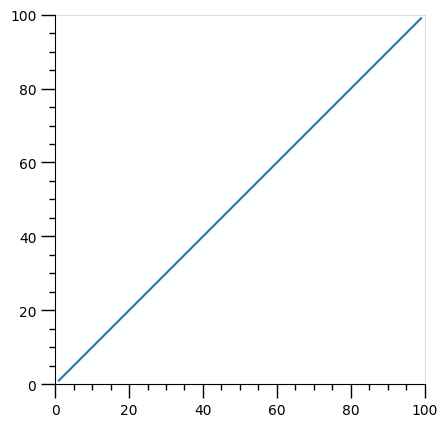

In [2]:
grid_color = "#dddddd"

f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.spines['top'].set_color(grid_color)
ax.spines['left'].set(zorder=10)
ax.spines['right'].set_color(grid_color)
ax.axis("square")

ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.tick_params(which='minor', width=1, length=4, color="#000000")
ax.tick_params(which='major', width=1, length=10, color="#000000")

# ax.grid(which="minor", color=grid_color, linestyle="-", lw=0.5)
# ax.grid(which="major", color=grid_color, linestyle="-")

ax.plot([1,99], [1,99], marker="None", linestyle="-", markersize=1)

## Convenience Functions

Use the `make_regression` function of scikit learn to generate a sample dataset with a single feature (see *univariate* below). Return the coefficient and recreate the linear function from which the dataset is generated. 

In [3]:
def uni_linear_regression_dataset():
    r = sklearn.datasets.make_regression(n_samples = 200,
                                         n_features = 1,
                                         noise=10.0,
                                         coef=True)
    return r[0].reshape(200,), r[1], r[2]

def f(w_1, x, w_0):
    return w_1 * x + w_0

def new_plot():
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(1,1,1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    return fig, ax

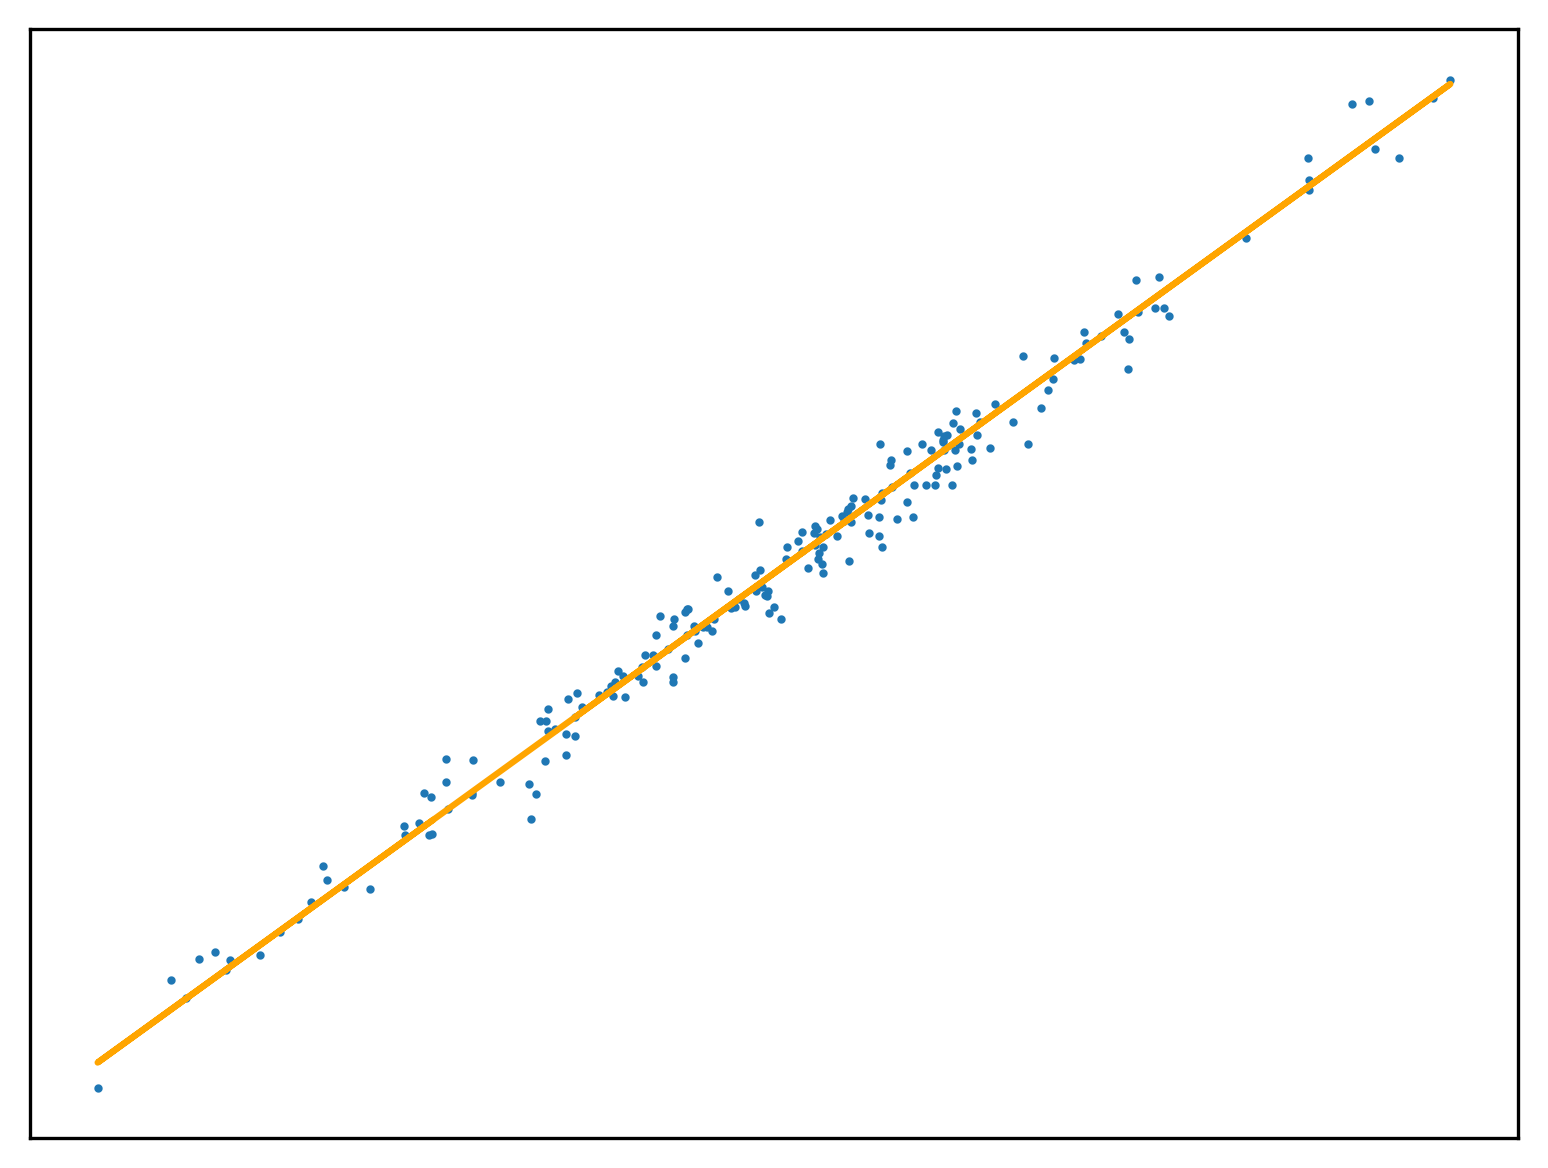

In [4]:
x,y,m = uni_linear_regression_dataset()
fig, ax = new_plot()
ax.scatter(x,y, s=1)
ax.plot(x, f(m, x, 0), 'orange')

## Univariable Linear Regression

The process of fitting a straight line to an $x$/$y$ dataset is called *univariate linear regression*, univariate refering to the single output variable $y$. In the most simple case, $x$ is a single value, though in more complicated cases $\mathbf{x}$ is a vector of values, linear regression applies to these cases equally well. Sometimes a function with a vector of inputs is called *multivariable* or even *multivariate*, despite a single dependent variable.

A simple linear function $h$ with one independent value is of the form $y=mx+c$, or in data science $y=w_1x+w_0$. The vector $\mathbf{w}$ is the vector of weights: $\langle w_0, w_1 \rangle$. The function of $x$ with weights $\mathbf{w}$ is:

$$h_{\mathbf{w}}=w_1x+w_0$$

The goal of linear regression is to calculate the values of the weights in $\mathbf{w}$ so that $h$ approximates the relationship between $x$ and $y$, by minimising loss. First, create the regression algorithm in the special case that $x$ is a single value, then generalise to a *n*-dimensional vector. 

### Loss Function

The loss for a single training example is a measure of how bad the current model is. Mean square loss is appropriate as it always returns a positive value.

$$g(w_0, w_1) = (h_{\mathbf{w}}(x) - y)^2$$

Average loss over many examples:

$$g(w_0, w_1) = \frac{1}{N}\sum_{n=1}^{N}(h_{\mathbf{w}}(x_n) - y_n)^2$$

These two functions, expressed in code:

In [5]:
def _mse(y_pred, y_actual):
    return (y_pred - y_actual) ** 2

def mse(y_actual, y_pred):
    loss = 0.0
    for i in range(y_actual.size):
        loss += _mse(y_pred[i], y_actual[i])
    return loss/y_actual.size

Compare the cost for the fitted line (the coefficeint is already know) with a line of gradient 1. The fitted line has a much smaller cost.

In [6]:
print(mse(y, f(m, x, 0))) # small cost
print(mse(y, f(1, x, 0))) # large cost

108.28740542530366
7772.260576298489


### Stochastic Gradient Descent

To perform regression, a function must be fitted to a dataset. For univariate linear regression, the paramaters can be computed exactly from the derivative of the loss function, though a different approach is required to fit more complex functions.

To this end, the weight space is traversed to find a suitable minimum by repeatedly adjusting the weights for each element $x$ in the training set, making a small step in the direction of steepest descent, according to the *learning rate* $\alpha$. If the loss represents how poor the current model is on a training example, the learning process should **minimise** this loss and hence the term *gradient descent* is preffered over hill-climbing.

Where $\mathbf{w}$ is the vector of weights as before, the gradient descent algorithm updates each weight by taking the partial derivative of the losss function $L$ with respect to that weight for each point $x$.

$$w_i \leftarrow w_i - \alpha \frac{\delta}{\delta w_i}L(x)$$

In [7]:
def SGD1(a, w_0, w_1, y, x):
    for i in range(x.size):
        w_0 -= (a * (f(w_1, x[i], w_0) - y[i]))
        w_1 -= (a * (f(w_1, x[i], w_0) - y[i]) * x[i])
    return w_0, w_1

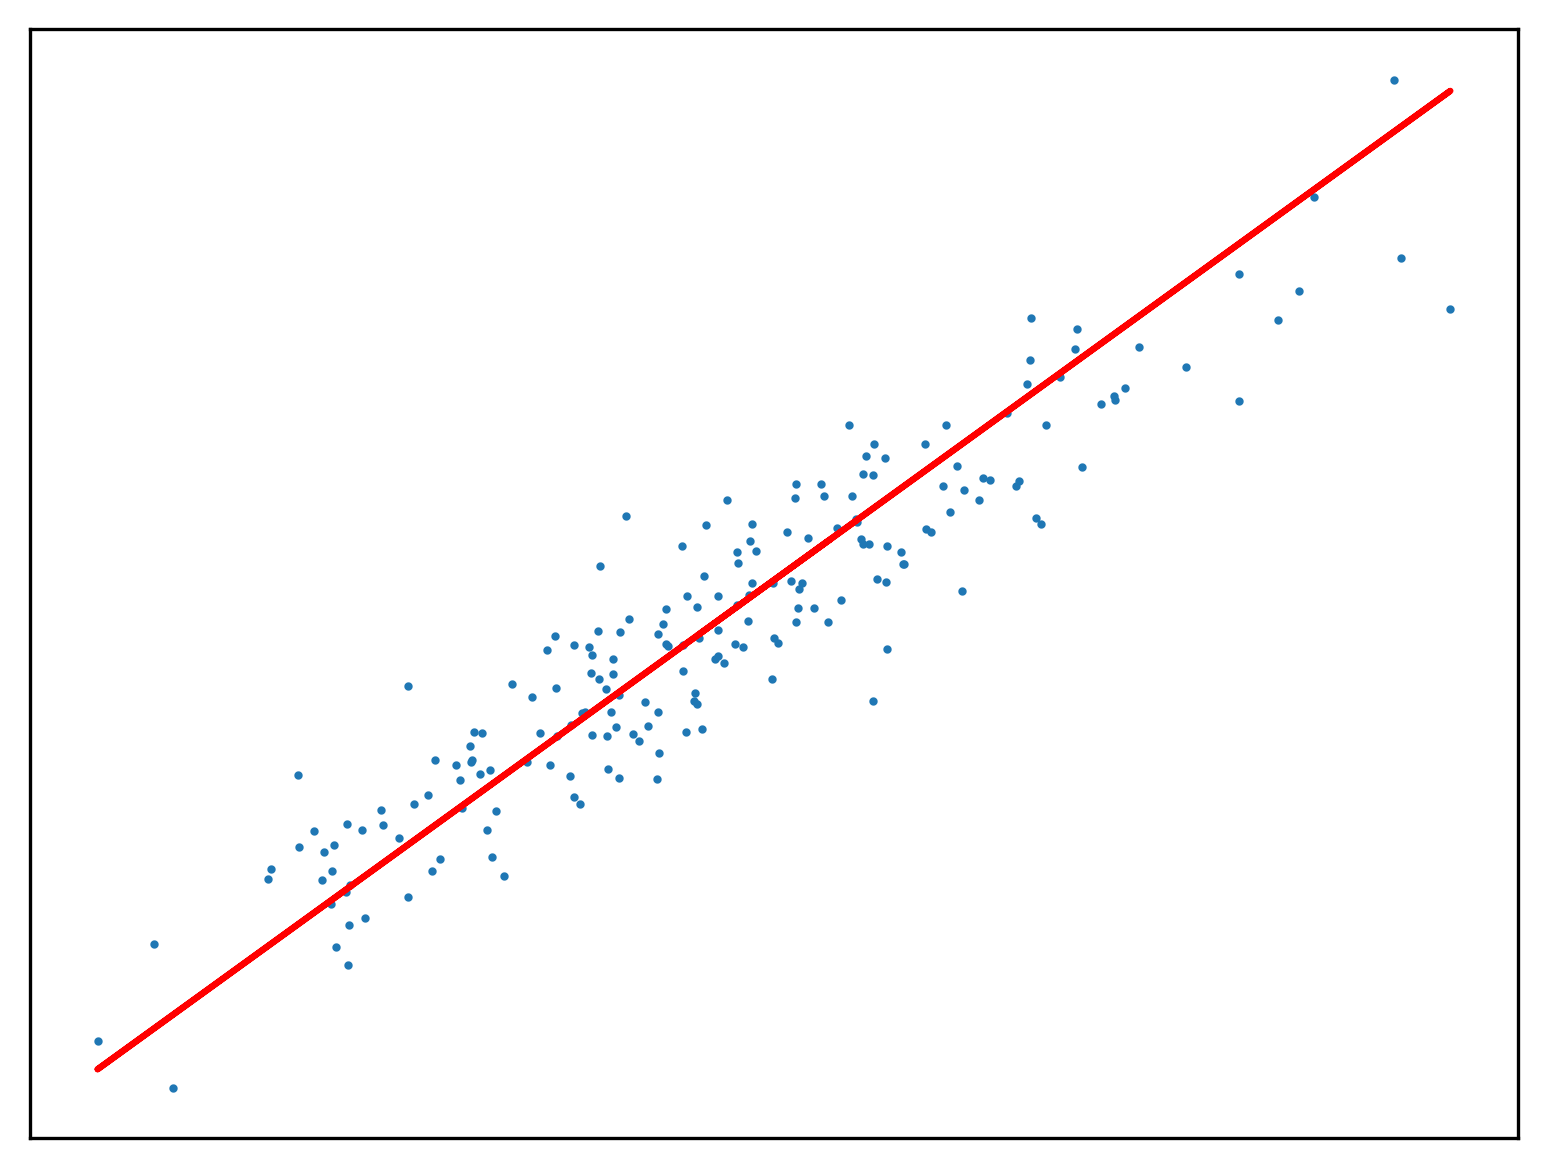

In [8]:
x,y,m = uni_linear_regression_dataset()
w_0 = w_1 = 0.0

w_0, w_1 = SGD1(0.1, w_0, w_1, y, x)

fig, ax = new_plot()
ax.scatter(x,y, s=1)
ax.plot(x, f(w_1, x, w_0), 'red')

### Deterministic Gradient Descent

Using the Stochastic approach to gradient descent, the function is tuned after calculating the loss of each element in $x$. An epoch is a step that observes all training examples. The total cost for a whole epoch can be determined and used to form a single change to $\mathbf{w}$.

In [9]:
def DGD1(a, w_0, w_1, y, x):
    w_0 -= (a * sum([f(w_1, x[i], w_0) - y[i] for i in range(x.size)]))
    w_1 -= (a * sum([(f(w_1, x[i], w_0) - y[i]) * x[i] for i in range(x.size)]))
    return w_0, w_1

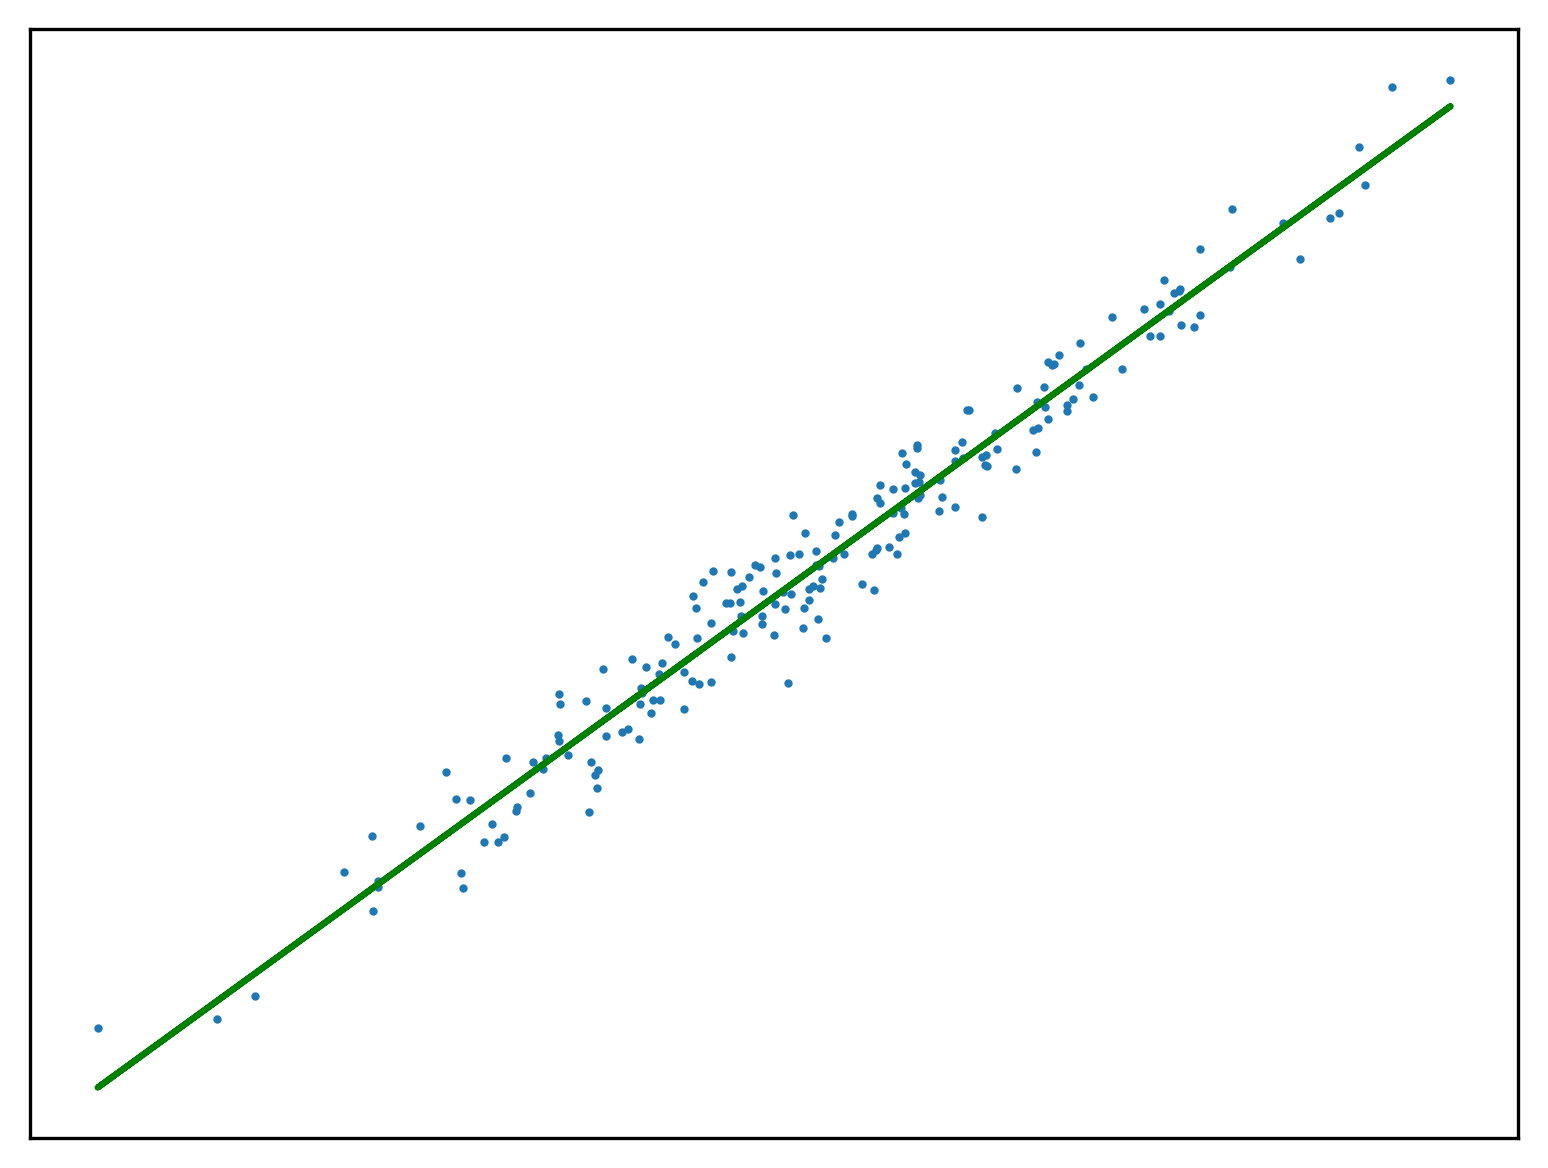

In [10]:
x,y,m = uni_linear_regression_dataset()
w_0 = w_1 = 0.0

for _ in range(100):
    w_0, w_1 = DGD1(0.001, w_0, w_1, y, x)

fig, ax = new_plot()
ax.scatter(x,y, s=1)
ax.plot(x, f(w_1, x, w_0), 'green')

### Mini-batch Gradient Descent

The stochastic gradient descent algorithm, observing the loss of one value of $x$, seen before is a special case of *mini-batch* gradient descent. The loss of all the points within a mini-batch are used to calculate a change to the vector of weights. This is preferred over either of the approaches seen before as it offers faster conversion than taking each element of the training set individually, without requiring the same system resources of fully determinisic gradient descent.

In [11]:
def SGD(a, n, w_0, w_1, y, x):
    x = x.reshape(-1, n)
    y = y.reshape(-1, n)
    for i in range(x.shape[0]):
        w_0 -= (a * sum([f(w_1, x[i][j], w_0) - y[i][j] for j in range(x[i].shape[0])]))
        w_1 -= (a * sum([(f(w_1, x[i][j], w_0) - y[i][j]) * x[i][j] for j in range(x[i].shape[0])]))
    return w_0, w_1

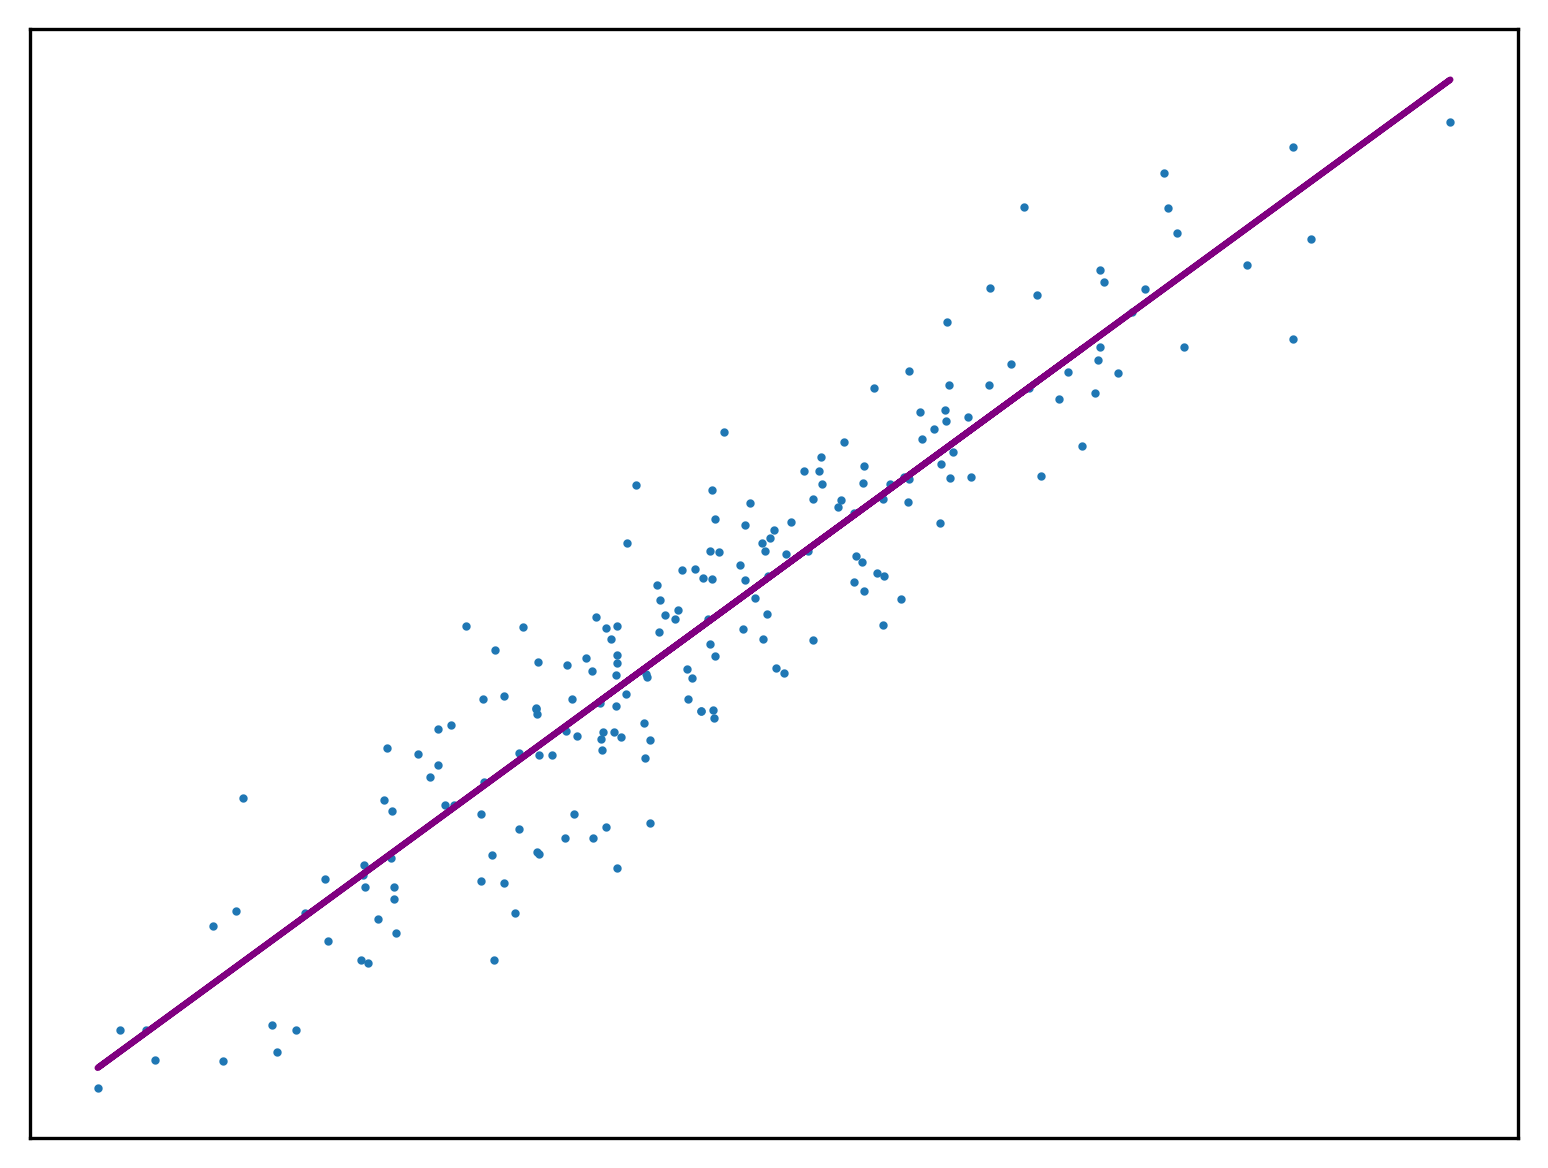

In [12]:
x,y,m = uni_linear_regression_dataset()
w_0 = w_1 = 0.0

for _ in range(1000):
    w_0, w_1 = SGD(0.01, 10, w_0, w_1, y, x)

fig, ax = new_plot()
ax.scatter(x,y, s=1)
ax.plot(x, f(w_1, x, w_0), 'purple')

## Multivariable Linear Regression

Multivariable linear regression applies to problems where each independent variable in the training dataset is a *n*-variable vector, rather than a single value.

$$h_\mathbf{w}(\mathbf{x}_j) = w_0 + w_ix_{j,1} + \cdots +w_nx_{j,n} = w_0 + \sum_{i=1}^{n}w_ix_{j,i}$$

The weight $w_0$ is the intercept. The function $h_\mathbf{w}$ can be simplified by introducing a new variable $x_0$ with the value 1, making $h_\mathbf{w}$ the product of the transposed weight vector with each corresponding element in $x$, $x_j$:

$$h_\mathbf{w}(\mathbf{x}_j) = \mathbf{w^{T}x_j} = \sum_{i = 0}^{n}w_ix_{j,i}$$

With this assignment, the partial derivative of the loss function with respect to each $w$ is the same.

$$w_i \leftarrow w_i - \alpha \sum_j(h_{\mathbf{w}}(\mathbf{x}_j) - y_j) \times x_{j,i}$$

In [16]:
def create_minibatches(a, m):
    n = int(x.shape[0] / m)
    return np.array_split(a[:m * n], n), n

def h(W, X):
    return sum(W * X)

def vector_SGD(a, m, W, y, X):
    X = np.concatenate((np.ones((X.shape[0],1), dtype=int), X), axis=1)
    X, n = create_minibatches(X, m)
    y, n = create_minibatches(y, m)
    for b in range(n):
        for w in range(W.size):
            W[w] -= a * sum([((h(W, X[b][x])) - y[b][x]) * X[b][x][w] for x in range(X[b].shape[0])])
    return W

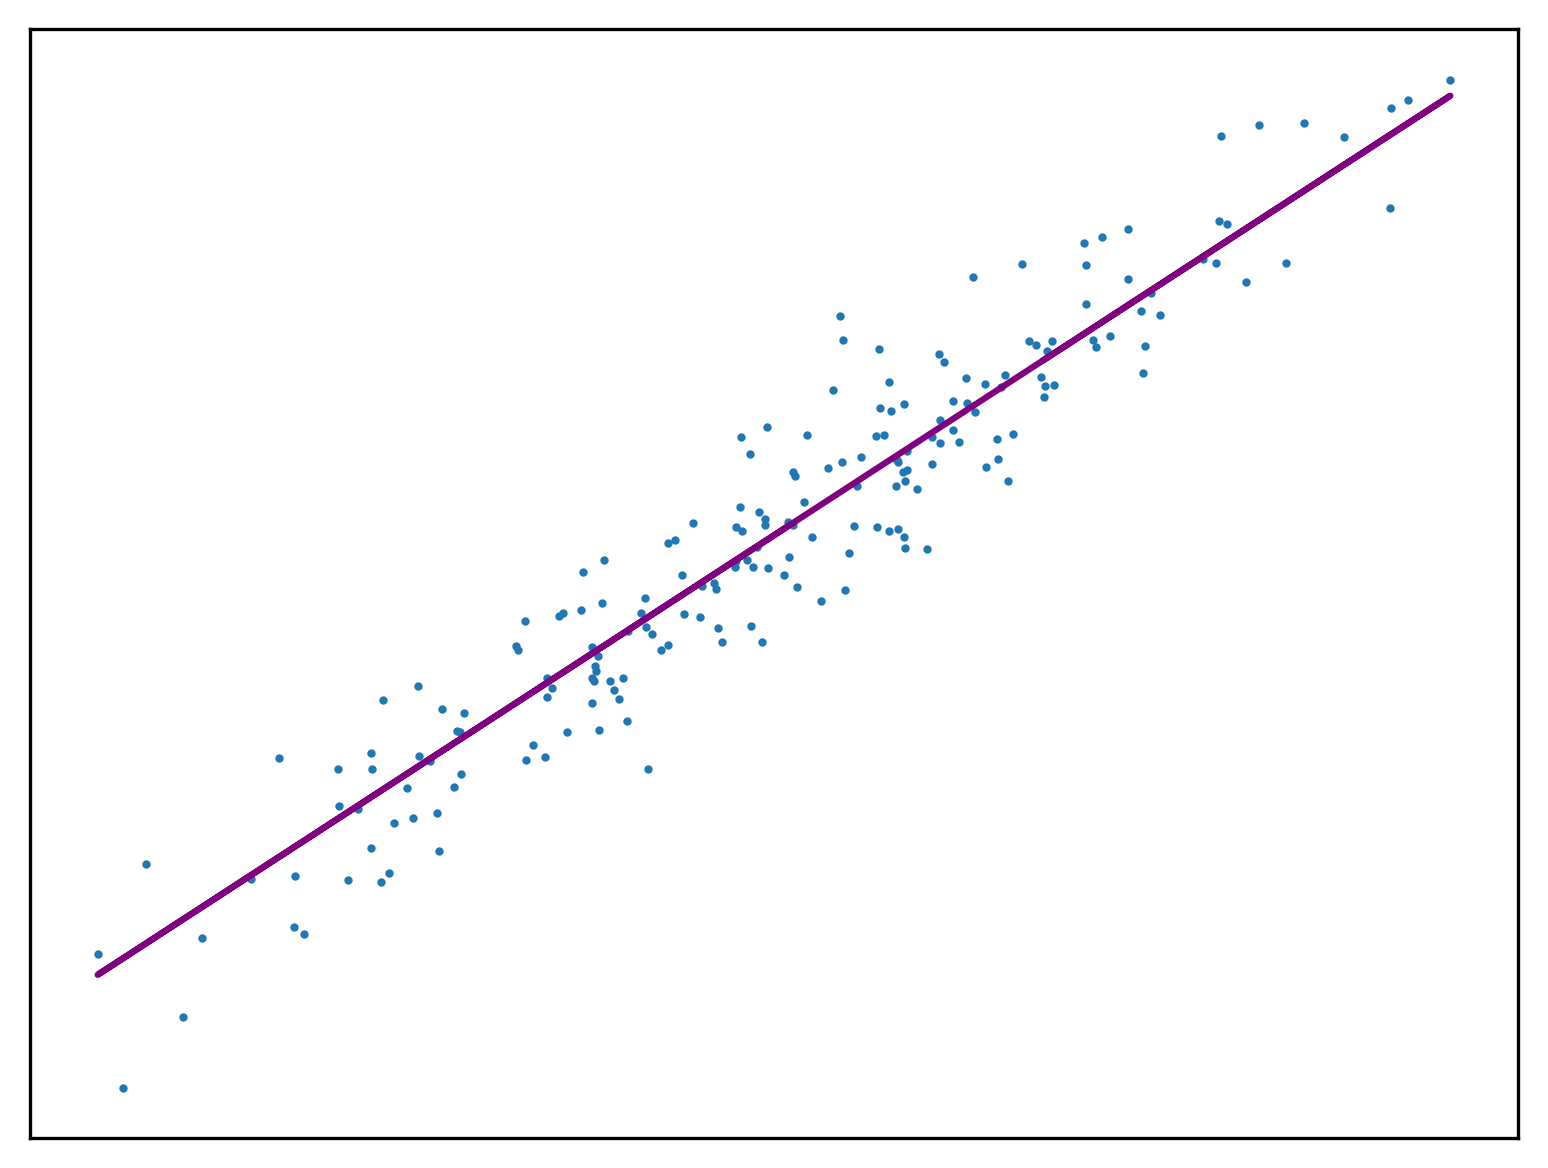

In [18]:
r = sklearn.datasets.make_regression(n_samples = 200, n_features = 1, noise=5.5, coef=True)
X = r[0]
y = r[1]
W = np.array([0,1])
W = vector_SGD(0.1, 10, W, y, X)
Z = np.concatenate((np.ones((200,1), dtype=int), X), axis=1)

fig, ax = new_plot()
ax.scatter(X,y, s=1)
ax.plot([Z[i][1] for i in range(Z.shape[0])], [h(W, Z[i]) for i in range(Z.shape[0])], 'purple')

[ 0 54 17]
[54.25043539 16.64445013]


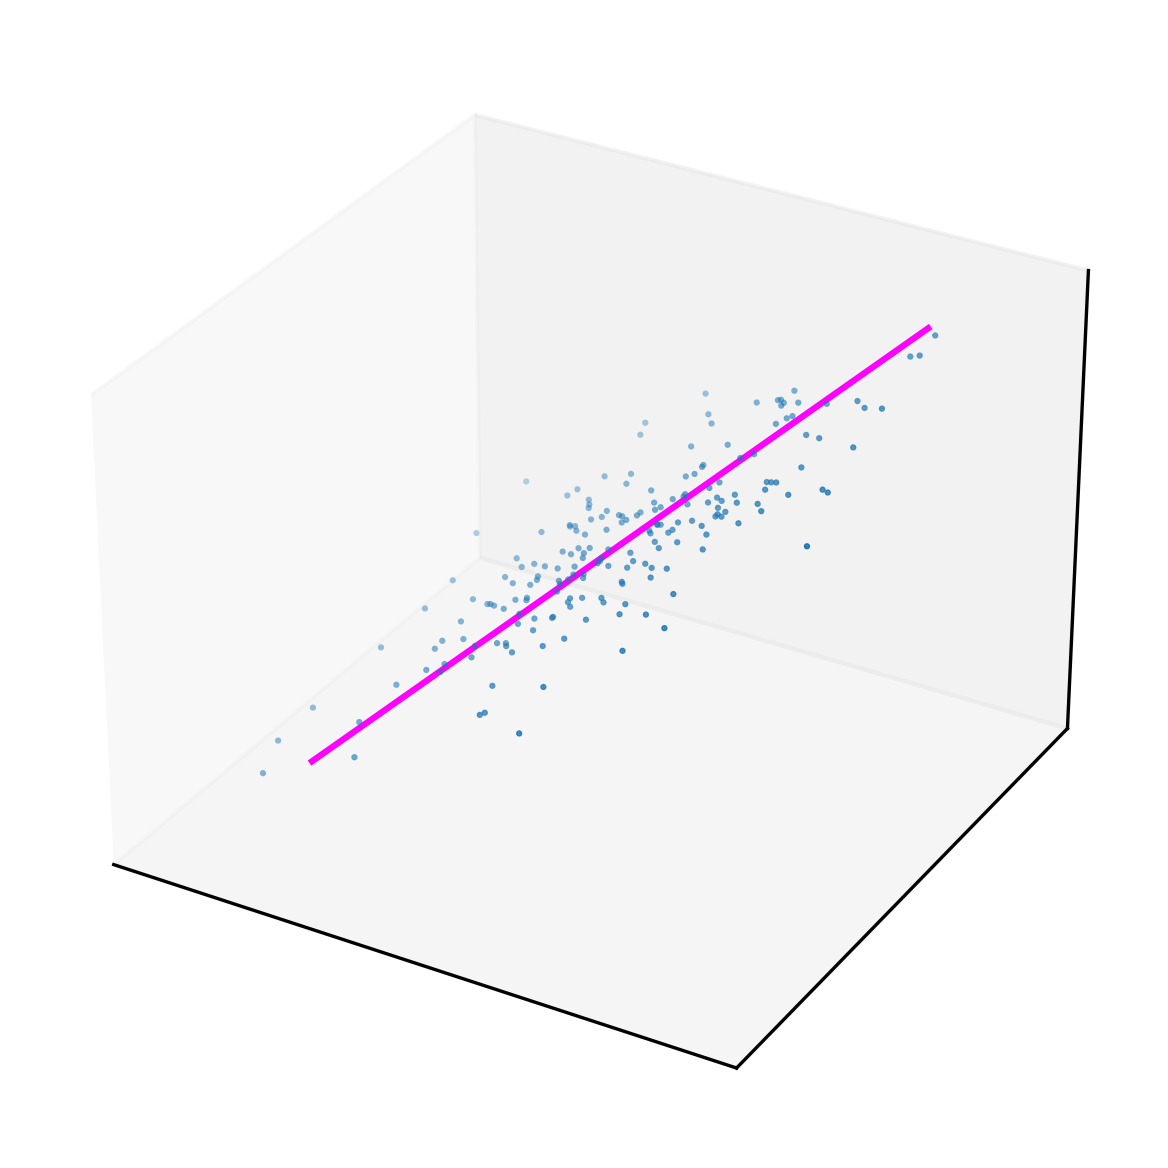

In [21]:
r = sklearn.datasets.make_regression(n_samples = 200,
                                     n_features = 2, noise=1.5,
                                     coef=True)
X = r[0]
y = r[1]

Z = np.concatenate((np.ones((100,1), dtype=int), np.linspace(-2, 2, 200).reshape(100,2)), axis=1)

W = np.array([0,1,1])
W = vector_SGD(0.1, 10, W, y, X)
print(W)
print(r[2])

fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.grid()
ax.scatter([X[i][0] for i in range(X.shape[0])], [X[i][1] for i in range(X.shape[0])],r[1], s=1, marker='.')
ax.plot([Z[i][1] for i in range(Z.shape[0])], [Z[i][2] for i in range(Z.shape[0])], [h(W, Z[i]) for i in range(Z.shape[0])], color='magenta')